# Low-Pass Filter (LPF) Post-Processing

When replaying curves naively, significant differences in peak-to-peak can arise between the original and replay. These discrepancies are due to the presence of high-frequency peaks that show up at replay time in abrupt changes in the system. These peaks are likely due to numerical errors introduced by the solver during the simulation.

To address this issue, a Low-Pass Filter (LPF) can be applied as a post-processing step. The LPF effectively smooths the replayed curves, removing high-frequency noise and ensuring that the peak-to-peak difference metric reflects meaningful differences rather than artifacts caused by numerical instability.

In this notebook we show the peaks that can appear when no post-processing is performed, and how LPF effectively removes the noise.

For this analysis, we use the `IEEE57_Fault` test case with Dynawo version 1.8.0. More concretely, we will be analysing the variable `generator_QGenPu` for the generator `GEN___12_SM`.

In [ ]:
%matplotlib inline

from dynawo_replay import ReplayableCase
from dynawo_replay.plotting import plot_curves_comparison

case = ReplayableCase(
    "./data/IEEE57_Fault/IEEE57.jobs",
    dynawo="./dynawo-1.8.0",
)
case.generate_replayable_base()

Below we perform a replay without applying the post-processing. Post-processing can be enabled/disabled using the argument `apply_postprocessing` or through the environment variable ```POSTPROCESS_ENABLED``` .

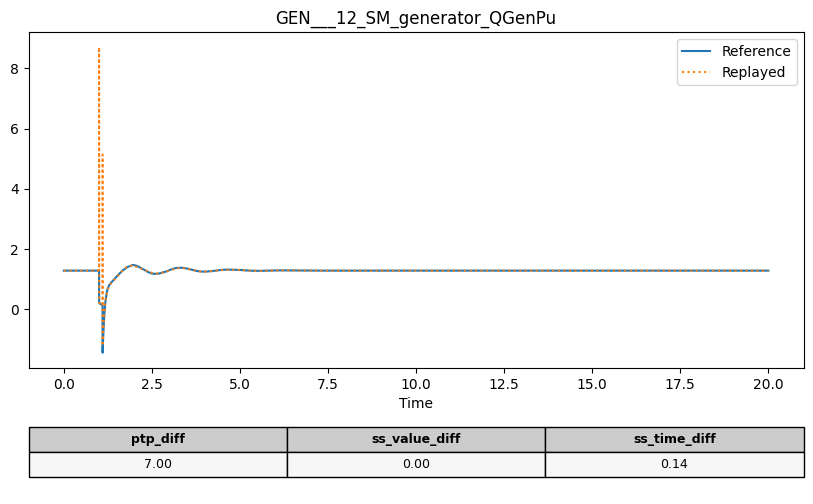

In [2]:
gen = "GEN___12_SM"
var = "generator_QGenPu"

replayed_df = case.replay(gen, [var], apply_postprocessing=False)
reference_df = case.calculate_reference_curves(gen, [var])

plot_curves_comparison(reference_df, replayed_df, f"{gen}_{var}")

We observe a significant error in `ptp_diff`, reaching up to 7 units. This error is caused by two sharp, narrow peaks occurring at 1s and 1.1s, which correspond to the fault's start and end times. The figure below zooms in on the first peak to illustrate this behavior.

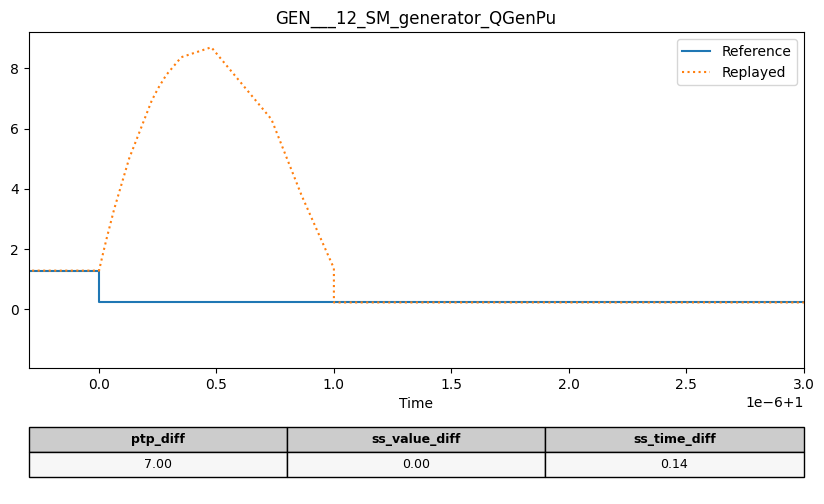

In [3]:
fig = plot_curves_comparison(reference_df, replayed_df, f"{gen}_{var}")
fig.axes[0].set_xlim([0.9999997, 1.000003])
fig

Within 1μs, the curve rises from 1.3 to 8.7 before dropping sharply to 0.2, instead of decreasing directly from 1.3 to 0.2. Such rapid oscillations over such a short time frame lack physical plausibility and are likely caused by numerical issues in the solver.

Let's focus then on the replayed curve and how we can remove these high frequency peaks.

<Axes: xlabel='time'>

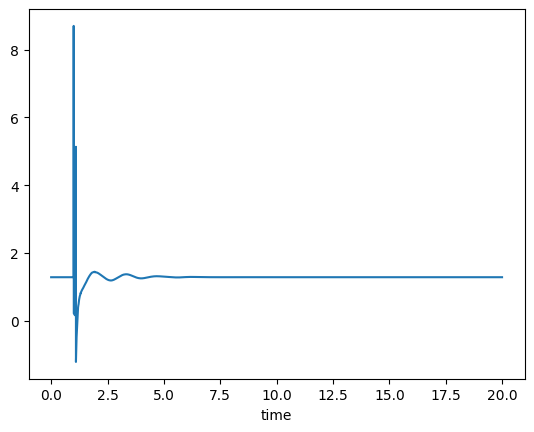

In [4]:
s = replayed_df[f"{gen}_{var}"]
s.plot()

To remove the high-frequency peaks, a low-pass filter (LPF) is applied. The implementation of this LPF is inspired by the work done in the [DyCov](https://github.com/dynawo/dyn-grid-compliance-verification) project, and the `lp_filters.py` module is a replica of the one in that repository.

Before applying the LPF, the curve must be reindexed to a fixed time step with a sufficiently fine resolution. This intermediate frequency is referred to as `intermediate_freq` in the code. For this notebook, we use an intermediate frequency of 10 kHz.

A preliminary step is required when using *pchip* interpolation: the time series must have a strictly increasing time index. Since Dynawo often returns curves with duplicate values for the same timestamp, the first step is to drop these duplicates.

The `lp_filters.py` module provides several LPF options, but here we use the 2nd-order critically damped LPF. The filter parameters `a` and `b` are calculated using the `critically_damped_lpf()` function, which takes the cutoff frequency and the sample frequency (the intermediate frequency) as arguments.

We also need to define the target frequency, `target_freq`, which specifies the frequency at which the final curve will be sampled. A good practice is to set the target frequency to twice the cutoff frequency of the LPF. For this notebook, we use a target frequency of 100 Hz, so that the cutoff frequency is 50 Hz.

After obtaining the filter parameters `a` and `b`, the filter is applied using `apply_filtfilt()`. Finally, the curve is resampled to the target frequency using *pchip* interpolation.

The complete post-processing workflow is implemented in the following cell.

<Axes: >

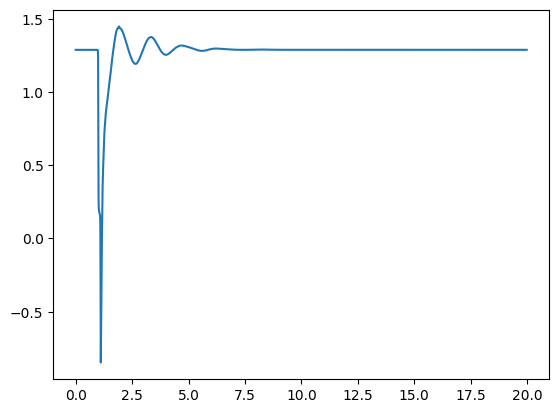

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import pchip_interpolate
from dynawo_replay.lp_filters import critically_damped_lpf, apply_filtfilt


def drop_duplicated_index(s: pd.Series):
    return s.loc[~s.index.duplicated()]


def reindex(s: pd.Series, new_index: np.array) -> pd.Series:
    new_values = pchip_interpolate(s.index, s.values, new_index)
    return pd.Series(new_values, index=new_index)


intermediate_freq = 1e4
target_freq = 100
cutoff_freq = target_freq / 2
b, a = critically_damped_lpf(cutoff_freq, intermediate_freq)

s = drop_duplicated_index(s)
t0, tf = s.index.min(), s.index.max()
intermediate_time_grid = np.arange(t0, tf, step=1 / intermediate_freq)
target_time_grid = np.arange(t0, tf, step=1 / target_freq)
s = reindex(s, intermediate_time_grid)
s = pd.Series(apply_filtfilt(b, a, s.values, padding_method="gust"), index=s.index)
s = reindex(s, target_time_grid)
s.plot()

The high-frequency peaks have now been eliminated.

The logic described above has been implemented in the `postprocess_curve()` function within the `dynawo_replay.utils` submodule. Postprocessing is applied during replay when the `apply_postprocess` argument is set to `True` (default). For command-line execution, postprocessing can be disabled by setting the environment variable `POSTPROCESS_ENABLED` to `False`.

The intermediate and target frequencies default to `1e4` and `1e2`, respectively. These values can be customized using the `POSTPROCESS_FINE_FREQ` and `POSTPROCESS_TARGET_FREQ` environment variables.

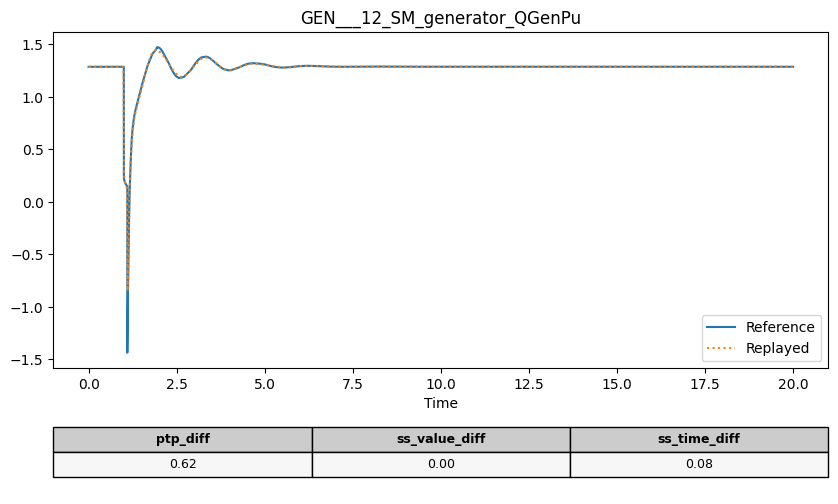

In [6]:
from dynawo_replay.utils import postprocess_curve


replayed_df = replayed_df.apply(postprocess_curve)


plot_curves_comparison(reference_df, replayed_df, f"{gen}_{var}")

The lines above demonstrate the results when postprocessing is enabled. The high-frequency peaks are effectively removed, and the `ptp_diff` metric now provides meaningful insights.